In [1]:
!pwd

/Users/yuki.matsumoto/Documents/Project/infonia/Git/InfoNear/jn/wine_quality


In [27]:
# ライブラリ読み込み
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics

from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score
sns.set()
%matplotlib inline

import os
import sys
import warnings
import gc

import feather

HOME_DIR = '/Users/yuki.matsumoto/Documents/Project/InfoNear/InfoNear'

# アプリ定数
PYSRC_DIR = os.path.join(HOME_DIR, 'py')
DATA_DIR = os.path.join(HOME_DIR, 'data/wine_quality')
EVAL_DIR = os.path.join(HOME_DIR, 'eval')

# 共通スクリプト呼び出し用にパスを通す
sys.path.append(PYSRC_DIR)

# dataフォルダに移動
os.chdir(DATA_DIR)
from glob import glob
glob('./*')

warnings.filterwarnings('ignore')
from copy import deepcopy

#可視化設定

plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'Ricty Diminised'
sns.set(style="whitegrid", font='Ricty Diminised', palette="muted",
        color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

import japanize_matplotlib


In [3]:
!pwd

/Users/yuki.matsumoto/Documents/Project/InfoNear/InfoNear/data/wine_quality


In [7]:
def kesson_table(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    kesson_table = pd.concat([null_val,percent],axis=1)
    kesson_table_ren_columns = kesson_table.rename(columns = {0:'lack num',1:'%'})
    return kesson_table_ren_columns

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
!ls

winequality-names.txt     winequality-red.csv
winequality-names.txt.bak winequality-white.csv


In [6]:
winequality_red_df = pd.read_csv('winequality-red.csv', delimiter=";")
winequality_white_df = pd.read_csv('winequality-white.csv', delimiter=";")    

In [9]:
print(f'winequality_red_df dataset has {winequality_red_df.shape[0]} rows and {winequality_red_df.shape[1]} columns.')
print(f'winequality_white_df dataset has {winequality_white_df.shape[0]} rows and {winequality_white_df.shape[1]} columns.')

winequality_red_df dataset has 1599 rows and 12 columns.
winequality_white_df dataset has 4898 rows and 12 columns.


In [10]:
display(winequality_red_df.head())
display(winequality_white_df.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [11]:
winequality_red_df["quality"].unique()

array([5, 6, 7, 4, 8, 3])

In [12]:
winequality_red_df["quality"].dtype

dtype('int64')

In [13]:
winequality_red_df["alcohol"].dtype

dtype('float64')

## PCA：実装

### 変数削減

In [15]:
from sklearn.decomposition import PCA #主成分分析

In [16]:
#行列の標準化
dfs = winequality_red_df.iloc[:, :-1].apply(lambda x: (x-x.mean())/x.std(), axis=0)
dfs.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946


In [17]:
#主成分分析の実行
pca = PCA()
feature = pca.fit(dfs)
# データを主成分空間に写像
feature = pca.transform(dfs)

In [18]:
# 主成分得点
pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(dfs.columns))]).head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-1.619023,0.450809,-1.773899,0.043727,0.066994,-0.913635,-0.160993,-0.282170,0.005096,-0.267676,0.048615
1,-0.798920,1.855972,-0.911405,0.547895,-0.018386,0.929423,-1.009513,0.762348,-0.520544,0.062813,-0.138099
2,-0.748245,0.881763,-1.171028,0.410892,-0.043517,0.401348,-0.539385,0.597759,-0.086830,-0.187384,-0.118192
3,2.356935,-0.269892,0.243413,-0.928160,-1.498680,-0.130976,0.344183,-0.455233,0.091548,-0.130352,0.316615
4,-1.619023,0.450809,-1.773899,0.043727,0.066994,-0.913635,-0.160993,-0.282170,0.005096,-0.267676,0.048615


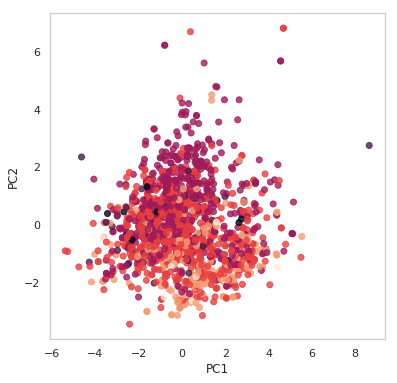

In [28]:
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=list(winequality_red_df.iloc[:, -1]))
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

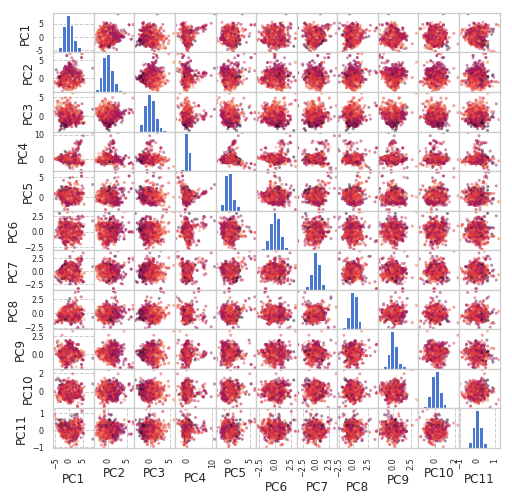

In [29]:
from pandas import plotting 
plotting.scatter_matrix(pd.DataFrame(feature, 
                        columns=["PC{}".format(x + 1) for x in range(len(dfs.columns))]), 
                        figsize=(8, 8), c=list(winequality_red_df.iloc[:, -1]), alpha=0.5) 
plt.show()

In [30]:
#寄与率と累積寄与率
pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(dfs.columns))])

,0
PC1,0.281739
PC2,0.175083
PC3,0.140958
PC4,0.110294
PC5,0.087208
PC6,0.059964
PC7,0.053072
PC8,0.038451
PC9,0.031331
PC10,0.016485


### 変数削減
    寄与率：１０％以上

In [33]:
#行列の標準化
pca_dfs = dfs[["fixed acidity","volatile acidity","citric acid","residual sugar"]]
pca_dfs.head()

,fixed acidity,volatile acidity,citric acid,residual sugar
0,-0.528194,0.961576,-1.391037,-0.453077
1,-0.298454,1.966827,-1.391037,0.043403
2,-0.298454,1.296660,-1.185699,-0.169374
3,1.654339,-1.384011,1.483689,-0.453077
4,-0.528194,0.961576,-1.391037,-0.453077


In [44]:
#主成分分析の実行
pca = PCA(n_components=2)
pca_feature = pca.fit(pca_dfs)
# データを主成分空間に写像
pca_feature = pca.transform(pca_dfs)

In [46]:
# 主成分得点
pd.DataFrame(pca_feature, columns=["PC{}".format(x + 1) for x in range(len(pca_dfs.columns)-2)]).head()

,PC1,PC2
0,-1.739429,-0.097951
1,-2.025369,0.719822
2,-1.597175,0.290037
3,2.500995,-0.815261
4,-1.739429,-0.097951


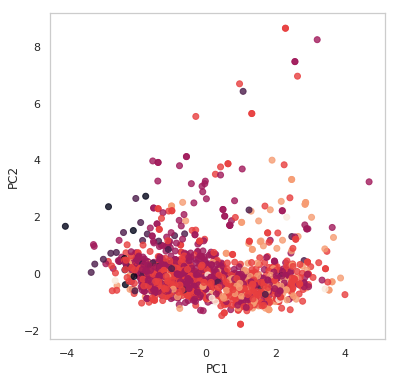

In [47]:
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(6, 6))
plt.scatter(pca_feature[:, 0], pca_feature[:, 1], alpha=0.8, c=list(winequality_red_df.iloc[:, -1]))
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [51]:
inv_pca_feature = pca.inverse_transform(pca_feature)
pd.DataFrame(inv_pca_feature, columns=["PC{}".format(x + 1) for x in range(len(pca_dfs.columns))]).head()

,PC1,PC2,PC3,PC4
0,-0.985127,0.816572,-1.127147,-0.357044
1,-1.086444,1.228348,-1.340080,0.367766
2,-0.876936,0.876261,-1.047563,0.029180
3,1.346928,-1.492309,1.652336,-0.384977
4,-0.985127,0.816572,-1.127147,-0.357044


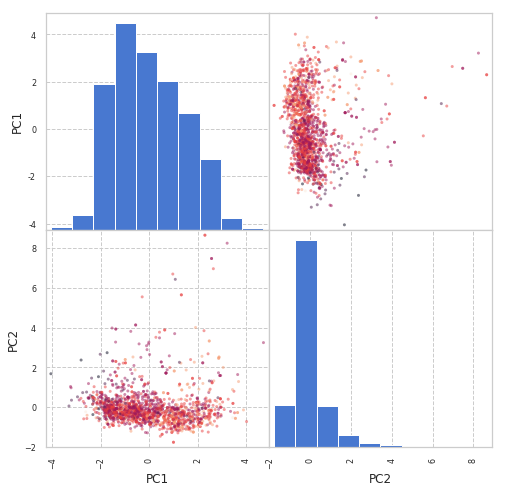

In [49]:
from pandas import plotting 
plotting.scatter_matrix(pd.DataFrame(pca_feature, 
                        columns=["PC{}".format(x + 1) for x in range(len(pca_dfs.columns)-2)]), 
                        figsize=(8, 8), c=list(winequality_red_df.iloc[:, -1]), alpha=0.5) 
plt.show()

In [42]:
#寄与率と累積寄与率
pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(pca_dfs.columns))])

,0
PC1,0.507464
PC2,0.251124
PC3,0.180939
PC4,0.060473
